Description goes here. Let's start by firing up the required libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries to generate street maps.
import folium
import branca

# Libraries and tools for our time series analysis.
import statsmodels.api as sm  
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Libraries for handling dates.
import datetime
from dateutil.relativedelta import relativedelta

# Ignore all warnings.
import warnings
warnings.filterwarnings('ignore')

# seaborn plotting style
sns.set(style='ticks', context='talk')


In [2]:
ts_month = pd.read_csv('./Time_Series_Accidents_Monthly.csv')
ts_month.head()

,Accidents
0,297
1,252
2,258
3,249
4,275


In [3]:
ts_month.shape

(108, 1)

In [4]:
df = pd.read_csv('./Birmingham_Accidents.csv')
df.head(3)


,Longitude,Latitude,Date,Day,Time,Local_Authority_(District),Road_Type,Speed_limit,Junction_Control,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Urban_or_Rural_Area,Year,Month,Week
0,-1.856683,52.484763,2009-02-01,Friday,19:15,300,Single carriageway,30.0,Automatic traffic signal,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Other,Wet/Damp,None,Urban,2009,2,5
1,-1.802605,52.525141,2009-02-01,Friday,10:24,300,Dual carriageway,40.0,Giveway or uncontrolled,None within 50 metres,Non-junction pedestrian crossing,Daylight: Street light present,Fine without high winds,Dry,None,Urban,2009,2,5
2,-1.766836,52.460347,2009-01-01,Thursday,02:17,300,Single carriageway,30.0,Not at junction or within 20 metres,None within 50 metres,No physical crossing within 50 meters,Darkness: Street lights present and lit,Other,Frost/Ice,None,Urban,2009,1,1


In [5]:
# Confirm that we only have Birmingham accidents in our data.
df["Local_Authority_(District)"].unique()


array([300])

In [6]:
# Drop column since all the accidents are from Birmingham.
df.drop(["Local_Authority_(District)"], axis=1, inplace=True)


In [7]:
df.shape

(24443, 18)

In [8]:
# Set date as index.
start = datetime.datetime.strptime("2009-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,108)] # edited to 108
ts_month['index']=date_list
ts_month.set_index(['index'], inplace=True)
ts_month.index.name=None

print(len(date_list))  # Check
print(len(ts_month.index))   # Check

108
108


<div class="alert alert-info" role="alert">
    
We will use ts_month to model and forecast our time series.

</div>

In [9]:
ts_month.head()


,Accidents
2009-01-01,297
2009-02-01,252
2009-03-01,258
2009-04-01,249
2009-05-01,275


In [10]:
ts_month.tail()

,Accidents
2017-08-01,224
2017-09-01,235
2017-10-01,207
2017-11-01,244
2017-12-01,227


In [11]:
# Check for null values.
df.isnull().sum()

Longitude                                  0
Latitude                                   0
Date                                       0
Day                                        0
Time                                       0
Road_Type                                  0
Speed_limit                                0
Junction_Control                           0
Pedestrian_Crossing-Human_Control          0
Pedestrian_Crossing-Physical_Facilities    0
Light_Conditions                           0
Weather_Conditions                         0
Road_Surface_Conditions                    0
Special_Conditions_at_Site                 0
Urban_or_Rural_Area                        0
Year                                       0
Month                                      0
Week                                       0
dtype: int64

In [12]:
df["Weather_Conditions"].value_counts()

Fine without high winds       11861
Fine no high winds             6489
Raining without high winds     2050
Other                          1248
Unknown                        1218
Raining no high winds           850
Raining with high winds         169
Fine with high winds            159
Snowing without high winds      137
Raining + high winds             85
Fine + high winds                79
Fog or mist                      50
Snowing no high winds            31
Snowing with high winds          15
Snowing + high winds              2
Name: Weather_Conditions, dtype: int64

### 1. Analyze Trends and Fluctuation around the Trend

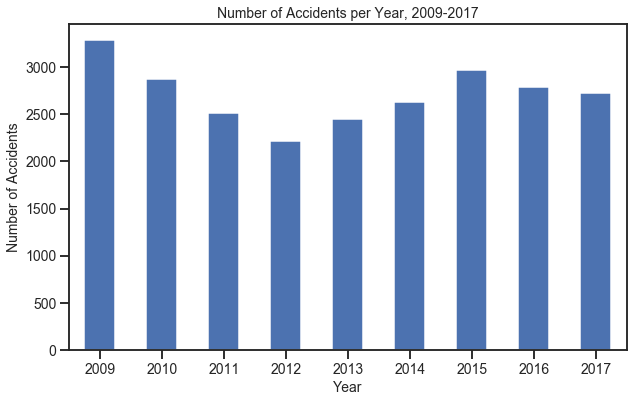

In [13]:
fig, ax = plt.subplots(figsize=(10,6));
# fig, ax = plt.subplots()
ax.set_ylabel('Number of Accidents', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Number of Accidents per Year, 2009-2017', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
df.groupby(['Year'])['Month'].count().plot(kind = 'bar', rot = 0)


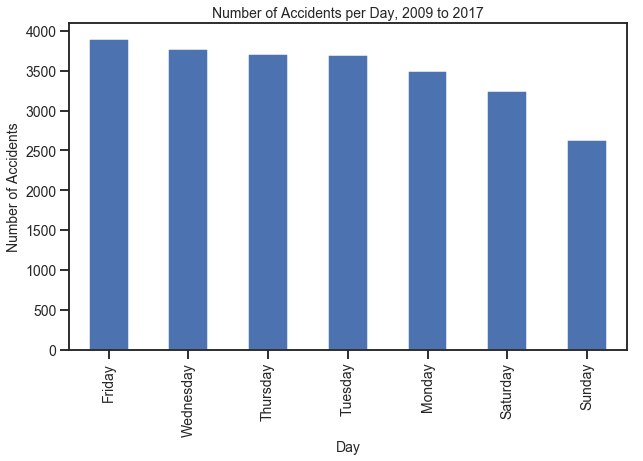

In [14]:
fig, ax = plt.subplots(figsize=(10,6));
# fig, ax = plt.subplots()
ax.set_ylabel('Number of Accidents', fontsize=14)
ax.set_xlabel('Day', fontsize=14)
ax.set_title('Number of Accidents per Day, 2009 to 2017', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
df['Day'].value_counts().plot(kind='bar')


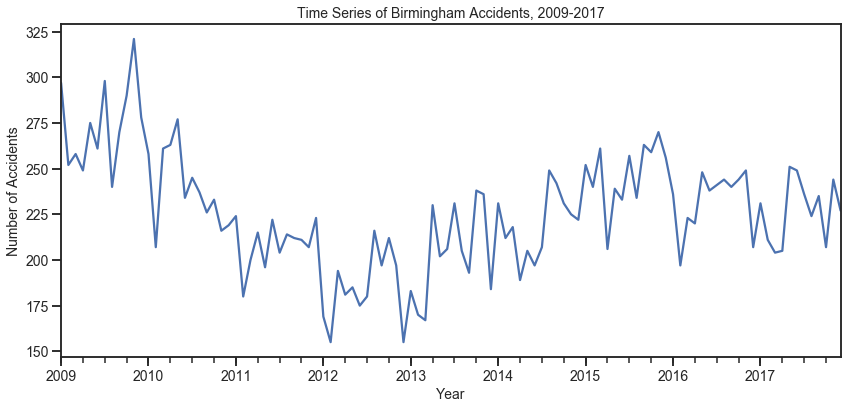

In [15]:
fig, ax = plt.subplots(figsize=(12,6));

ts_month['Accidents'].plot(ax=ax);

ax.set_title('Time Series of Birmingham Accidents, 2009-2017', fontsize=14);
ax.set_ylabel('Number of Accidents', fontsize=14);
ax.set_xlabel('Year', fontsize=14);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();
fig.subplots_adjust(top=0.9)


### Observation

It appears that the structure of the time series changed over tme. Accidents have been decreasing year-on-year from 2009 to 2013 (i.e. non-stationary data). However, it picked up over the next few years, and levelled off from 2016 onwards.  There also appears to be some seasonal variation (repeating cycle that happens on a regular timeframe) in the data.  As the size of the seasonal and random fluctuations remained relative for the time series, we can say that the time series is an additive model.

If we extend the line from 2018 onwards, how will our series look like? Will it be fairly relative? It is important to note the change in structure of the time series as it will rely on historical data to forecast the future. In a situation where the historical data is not applicable to what we think will happen in the future, regardless how good our model is, it may capture the past but not predict the future.

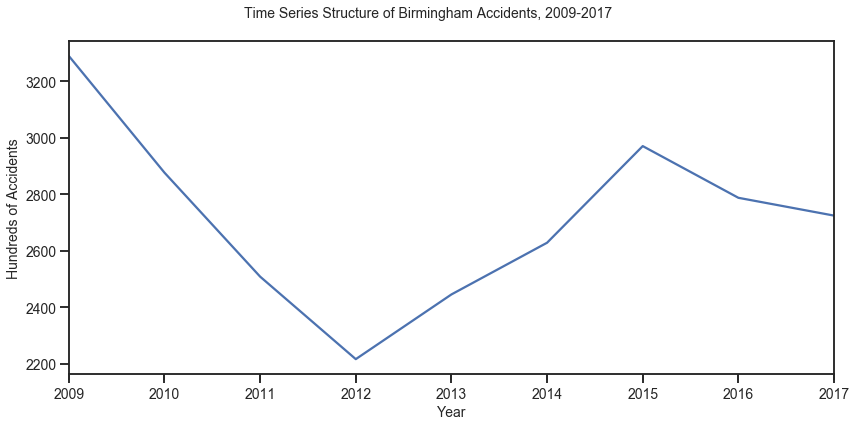

In [16]:
# Examine annual trend in the data.
fig, ax = plt.subplots(figsize=(12,6));

ts_month['Accidents'].resample('AS').sum().plot(ax=ax)

# ax.set_title('Birmingham Accidents, 2009-2017');
fig.suptitle('Time Series Structure of Birmingham Accidents, 2009-2017', fontsize=14);
ax.set_ylabel('Hundreds of Accidents',fontsize=14);
ax.set_xlabel('Year', fontsize=14);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

### 2. Test for Stationarity

We can test for stationarity through a visual test. Although its very clear that we have a trend (varying mean) in the above series, this approach might not always yield accurate results. It is better to confirm our observations using some statistical tests.

<b>Augmented Dickey-Fuller Test</b> is popular formal statistical test for stationarity.  The test checks the presence of unit root in the series - an indication that the statistical properties of a given series are not constant with time, which is the condition for stationary time series. And hence, help us understand if the series is stationary or not.  

The following hypothesis is employed for the test:

>H0: The time series is not stationary.<br>
>H1: The time series is stationary.


In [17]:
# Define a Dickey-Fuller test.
def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


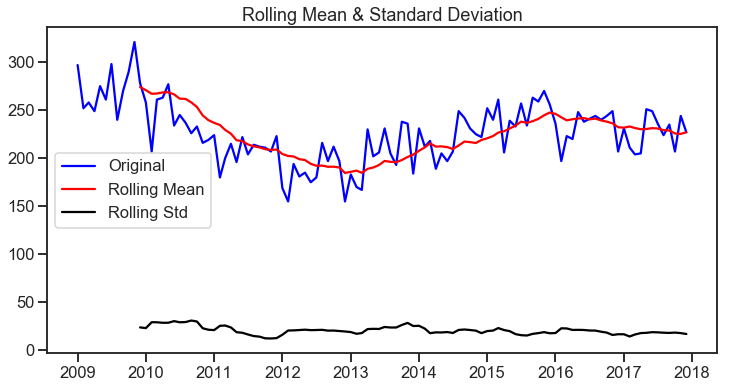

Results of Dickey-Fuller Test:
Test Statistic                  -1.879325
p-value                          0.341849
#Lags Used                       5.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [18]:
test_stationarity(ts_month.Accidents)


### Observations

We interpret this result using the p-value and test statistic.

> <b>p-value: The probability that our test result is not by chance.</b> A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).<br><br>
> <b>Test statistic: A negative number.</b> The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence. Hence, If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). But when the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).


> p-value > 0.05: Accept H0, the series is not stationary.<br>
> p-value ≤ 0.05: Reject H0, the series is stationary.

The p-value (0.34) > 0.05 threshold, which implies that the series is <b> not stationary</b>. Thus, we do not have sufficient evidence to reject the null hypothesis, which confirms our initial observation we saw in the visual test. In addition, the test statistic > critical value, which further confirms that the series is not stationary.

However, it is always better to apply both the tests, so that we are sure that the series is truly non-stationary. Let us look at the possible outcomes of applying the next stationary test.

<b>KPSS (Kwiatkowski-Phillips-Schmidt-Shin)</b> is another test for checking the stationarity of a time series (albeit slightly less popular than the Augmented Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series.

>H0: The time series is stationary.<br>
>H1: The time series is not stationary.


In [19]:
# Define a KPSS test.
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

In [20]:
kpss_test(ts_month.Accidents)


Results of KPSS Test:
Test Statistic            0.176245
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### Observations

> p-value > 0.05: Accept H0, the series is stationary.<br>
> p-value ≤ 0.05: Reject H0, the series is not stationary.

From the results above, the p-value (0.1) > 0.05 threshold, and hence we can say that the series is <b>stationary</b>.

The tests show contradictory results. The Augmented Dickey-Fuller Test shows that the series is non-stationary while the other shows that the series is! As it turns out, there are more than one type of stationarity.

> Case 1: Both tests conclude that the series is not stationary -> series is <b>not stationary.</b><br>
> Case 2: Both tests conclude that the series is stationary -> series is <b>stationary.</b><br>
> Case 3: KPSS = stationary and ADF = not stationary  -> <b>trend stationary</b>, remove the trend to make series strict stationary.<br>
> Case 4: KPSS = not stationary and ADF = stationary -> <b>difference stationary</b>, use differencing to make series stationary.

<div class="alert alert-danger">

### Is the time series stationary?

- KPSS = stationary & ADF = not stationary.

<b>No, our time series is not stationary. We have to remove the trend to make it stationary.</b>

</div>

### 3. Make the Series Stationary

It is important to know that achieving a perfectly stationary series is almost impossible, but we can try to take it as close as possible.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

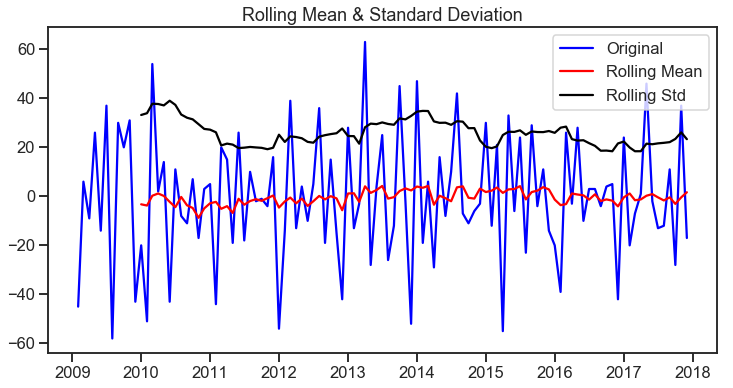

Results of Dickey-Fuller Test:
Test Statistic                -7.826813e+00
p-value                        6.448816e-12
#Lags Used                     4.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (1%)           -3.496149e+00
Critical Value (5%)           -2.890321e+00
Critical Value (10%)          -2.582122e+00
dtype: float64


In [21]:
# First difference.
# ts_month['First_Diff'] = ts_month.Accidents - ts_month.Accidents.shift(1)  
First_Diff = ts_month.Accidents - ts_month.Accidents.shift(1)  
test_stationarity(First_Diff.dropna(inplace=False))


### Observations

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller p-value is much < 0.05, and test statistic is far < 1% critical value, thus we can say with 99% confidence that the series is stationary. Let us look at the possible outcomes of applying KPSS.

In [22]:
kpss_test(First_Diff.dropna(inplace=False))

Results of KPSS Test:
Test Statistic            0.243841
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### Observations

> p-value > 0.05: Accept H0, the series is stationary.<br>
> p-value ≤ 0.05: Reject H0, the series is not stationary.

From the results above, the p-value (0.1) > 0.05 threshold, and hence we can say that the series is <b>stationary</b>. We can also take second order or seasonal differences which might get even better results in certain applications. 

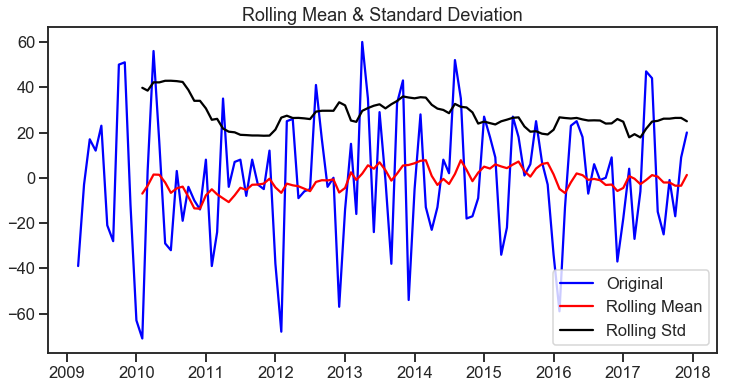

Results of Dickey-Fuller Test:
Test Statistic                 -5.537247
p-value                         0.000002
#Lags Used                      7.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [23]:
# Second difference.
# ts['second_diff'] = ts.Accidents - ts.Accidents.shift(2) 
second_diff = ts_month.Accidents - ts_month.Accidents.shift(2) 
test_stationarity(second_diff.dropna(inplace=False))


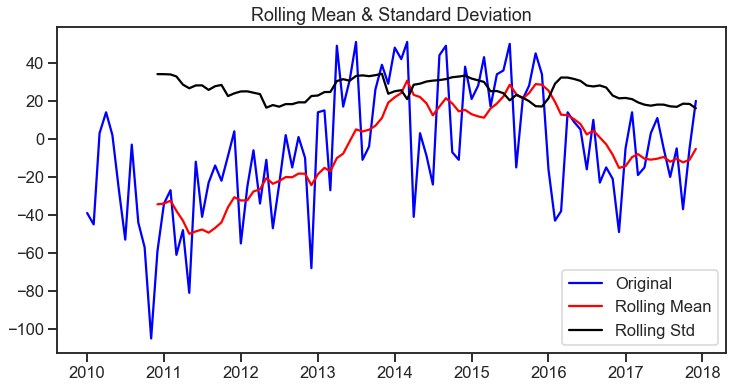

Results of Dickey-Fuller Test:
Test Statistic                 -2.212523
p-value                         0.201732
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [24]:
# Seasonal differencing.
n=12
# ts['seasonal_diff'] = ts.Accidents - ts.Accidents.shift(n)
seasonal_diff = ts_month.Accidents - ts_month.Accidents.shift(n)
test_stationarity(seasonal_diff.dropna(inplace=False))


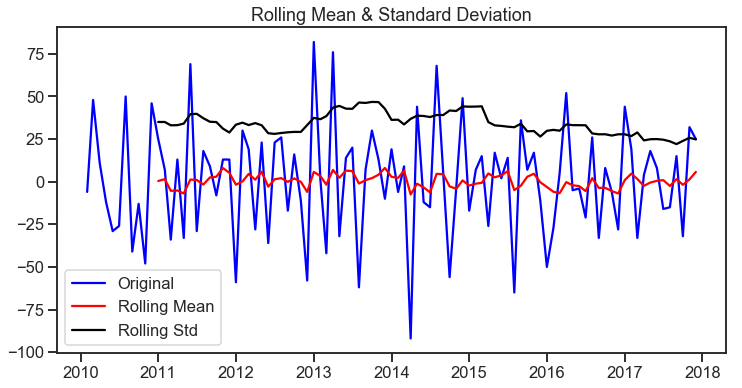

Results of Dickey-Fuller Test:
Test Statistic                 -3.598489
p-value                         0.005790
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [25]:
# Seasonal first differencing.
# ts['seasonal_first_diff'] = ts.first_diff - ts.first_diff.shift(12)  
seasonal_first_diff = First_Diff - First_Diff.shift(12)  
test_stationarity(seasonal_first_diff.dropna(inplace=False))


<div class="alert alert-success">

### Is the time series stationary?

- KPSS = stationary & ADF = stationary.

<b>Yes, our time series is stationary after first difference.</b>

</div>

### 4. Decompose the Series

<Figure size 432x288 with 0 Axes>

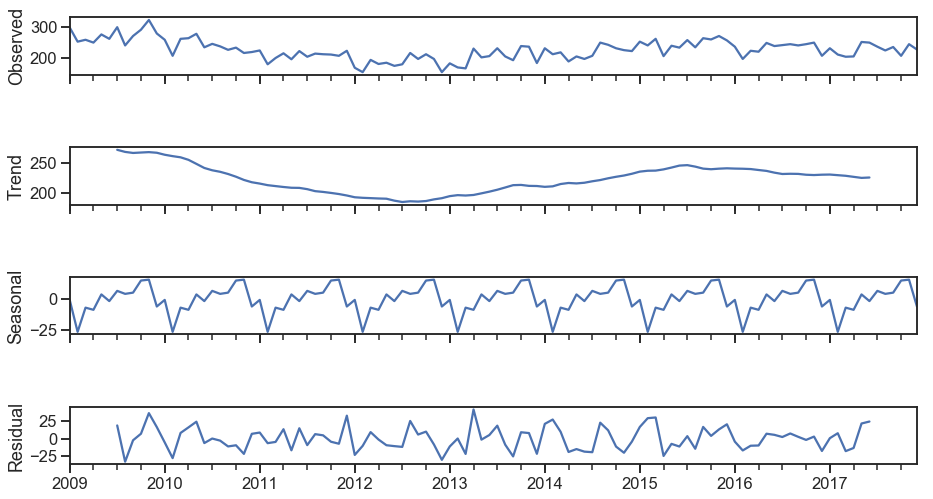

In [26]:
# ts_month.drop(columns= "First_Diff", inplace=True)
decomposition = seasonal_decompose(ts_month, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


### Observations

- The monthly accident rate has been trending downwards from 2009 and reached its lowest in 2012, before showing indications of a rising trend from 2013 onwards.
- It appears that accidents in the UK are highly seasonal - there is a dip every Jan. This is an interesting observation, and seems rather counter-intuitive, since we usually think of Christmas as a busy period of the year with families travelling on the road and visiting each other!

### 5. Analyse Dependency Structure

In [27]:
# Drop the null value in the first row before plotting correlograms.
First_Diff.dropna(inplace=True)
second_diff.dropna(inplace=True)
seasonal_diff.dropna(inplace=True)
seasonal_first_diff.dropna(inplace=True)

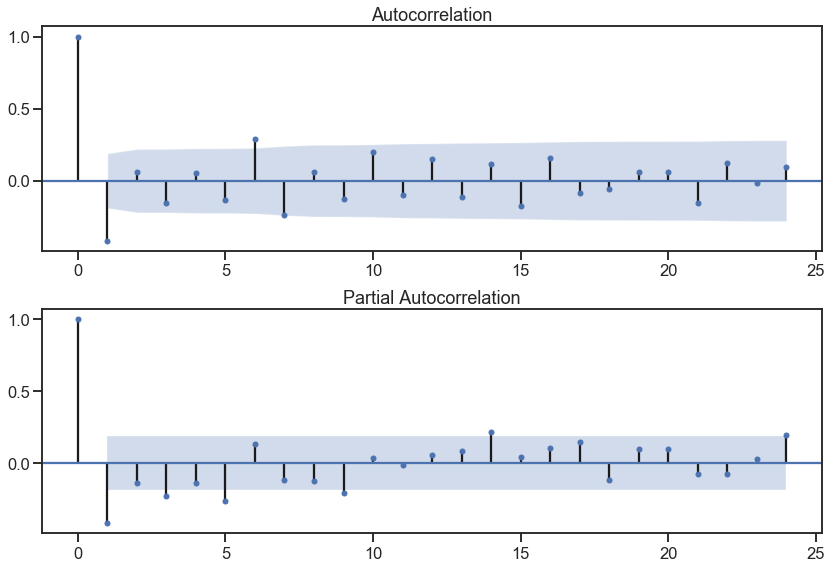

In [28]:
# Display big ACF and PACF plots.
# ts.drop('first_diff', axis=1, inplace=True)
# ts.drop('seasonal_diff', axis=1, inplace=True)

fig = plt.figure(figsize=(12,8))
 
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(First_Diff, lags=24, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(First_Diff, lags=24, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Observation

### 6. Create Train Test Data

In [29]:
# Examine the basic structure of the data
print("Data shape:", First_Diff.shape, "\n")
print("First 5 observations of the data series:", "\n", First_Diff.head())
print("Last 5 observations of the data series:", "\n", First_Diff.tail())


Data shape: (107,) 

First 5 observations of the data series: 
 2009-02-01   -45.0
2009-03-01     6.0
2009-04-01    -9.0
2009-05-01    26.0
2009-06-01   -14.0
Name: Accidents, dtype: float64
Last 5 observations of the data series: 
 2017-08-01   -12.0
2017-09-01    11.0
2017-10-01   -28.0
2017-11-01    37.0
2017-12-01   -17.0
Name: Accidents, dtype: float64


In [30]:
# Create train and test data.
n_sample = First_Diff.shape[0]
n_train = int(0.80 * n_sample)
n_test = n_sample - n_train
print("TS Shape:", n_sample)
print("n_train:", n_train)
print("n_test:", n_test)

TS Shape: 107
n_train: 85
n_test: 22


In [31]:
train = First_Diff.head(n_train)
test = First_Diff.tail(n_test)
print(train.shape)
print(test.shape)

(85,)
(22,)


### 7. "Gridsearch" Hyperparameters

In [32]:
# Find parameters 3
import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))      #Generate all different combinations of p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]       #Generate all different combinations of seasonal p, q and q triplet

In [33]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           #Specify to ignore warning messages
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(First_Diff, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            #print('ARIMA{}x{}-AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

In [34]:
AIC_df.head().sort_values(by="AIC")

,param,param_seasonal,AIC
3,"(0, 0, 0)","(0, 1, 1, 12)",772.516631
1,"(0, 0, 0)","(0, 0, 1, 12)",870.293956
4,"(0, 0, 0)","(1, 0, 0, 12)",880.575600
2,"(0, 0, 0)","(0, 1, 0, 12)",925.120782
0,"(0, 0, 0)","(0, 0, 0, 12)",988.925399


### 8. Train and Test First Model

In [35]:
train.shape

(85,)

In [36]:
model1 = sm.tsa.statespace.SARIMAX(train,order=(0,0,0),seasonal_order=(0,1,1,12),
                                   enforce_stationarity=False, enforce_invertibility=False).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                Accidents   No. Observations:                   85
Model:             SARIMAX(0, 1, 1, 12)   Log Likelihood                -286.744
Date:                  Tue, 26 Feb 2019   AIC                            577.488
Time:                          17:15:37   BIC                            581.677
Sample:                      02-01-2009   HQIC                           579.127
                           - 02-01-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000   2818.401     -0.000      1.000   -5524.965    5522.965
sigma2       645.3296   1.82e+06      0.000      1.000   -3.56e+06    3.57e+06
===================================================================================
Ljung-Box (Q):                       62.04   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.01   Prob(JB):                         0.55
Heteroskedasticity (H):               0.88   Skew:                             0.20
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Create First_Diff column.
ts_month["First_Diff"] = ts_month.Accidents - ts_month.Accidents.shift(1)

In [38]:
# Forecast on the test data. 
ts_month['Forecast_Test1'] = model1.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
forecast = model1.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
ts_month.tail(30)

,Accidents,First_Diff,Forecast_Test1
2015-07-01,257,24.0,NaN
2015-08-01,234,-23.0,NaN
2015-09-01,263,29.0,NaN
2015-10-01,259,-4.0,NaN
2015-11-01,270,11.0,NaN
2015-12-01,256,-14.0,NaN
2016-01-01,236,-20.0,NaN
2016-02-01,197,-39.0,NaN
2016-03-01,223,26.0,20.427630
2016-04-01,220,-3.0,-3.714115


### 9. Analyze Model Performance

In [39]:
# Calculate residuals for each point.
y_hat1 = ts_month.loc["2016-03-01":"2017-12-01"]["Forecast_Test1"]
y1 = ts_month.loc["2016-03-01":"2017-12-01"]["First_Diff"]
forecast_error1 = y1 - y_hat1
forecast_error1


2016-03-01     5.572370
2016-04-01     0.714115
2016-05-01    21.428874
2016-06-01    -2.714622
2016-07-01   -10.427952
2016-08-01     6.856965
2016-09-01    -5.142804
2016-10-01    -6.142390
2016-11-01     5.285701
2016-12-01   -22.715175
2017-01-01    21.714391
2017-02-01     7.430191
2017-03-01   -27.427630
2017-04-01     4.714115
2017-05-01    39.428874
2017-06-01     5.285378
2017-07-01   -26.427952
2017-08-01    -8.143035
2017-09-01     9.857196
2017-10-01   -38.142390
2017-11-01    37.285701
2017-12-01     2.284825
dtype: float64

In [40]:
mae = mean_absolute_error(y1, y_hat1)
print('MAE: %f' % mae)

mse = mean_squared_error(y1, y_hat1)
print('MSE: %f' % mse)

MAE: 14.324666
MSE: 357.180449


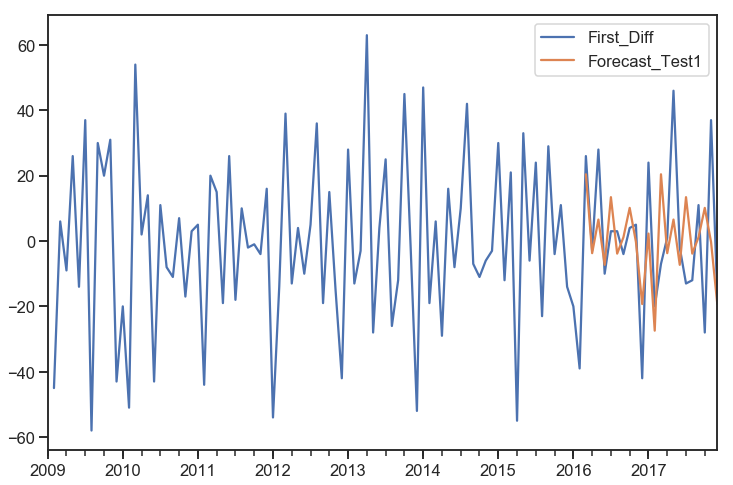

In [41]:
ts_month[['First_Diff', 'Forecast_Test1']].plot(figsize=(12, 8)) 

### Observations

The model wasn't great, but neither was it bad. It managed to capture the variations but missed out on big spikes in accidents. Further parameter tuning is required to capture those peaks.

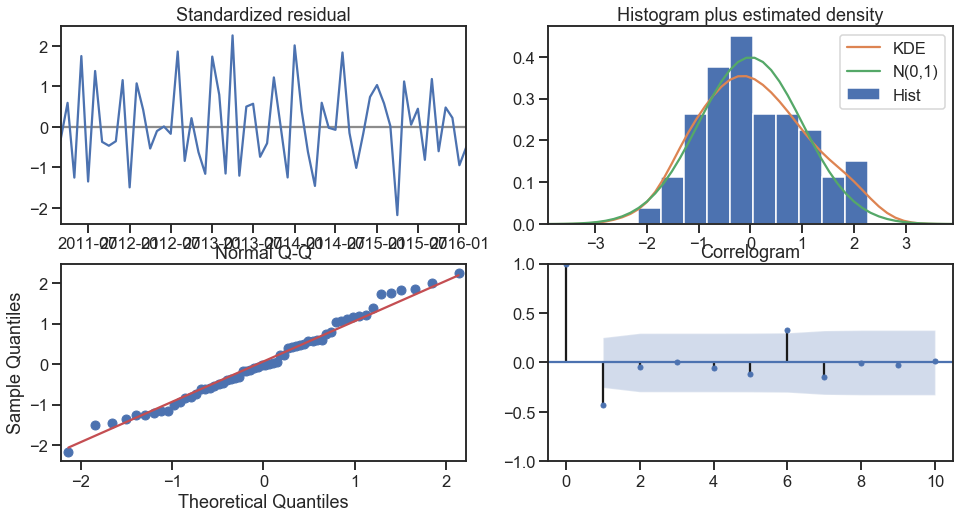

In [42]:
# Residual Diagnostics
# The plot_diagnostics function associated with the estimated result object produce a few plots that allow us 
# to examine the distribution and correlation of the estimated residuals.
model1.plot_diagnostics(figsize=(16, 8))
plt.show()

In [43]:
residuals = pd.DataFrame(model1.resid)
# residuals.plot(figsize=(10, 6))
residuals.describe()

,0
count,85.000000
mean,1.045232
std,30.096831
min,-59.833073
25%,-20.000000
50%,-0.750101
75%,23.335197
max,64.249899


In [44]:
# Prepare to extend the line and forecast 12 months ahead.
start = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= ts_month.columns)
ts_month = pd.concat([ts_month, future])
ts_month.tail(30)

,Accidents,First_Diff,Forecast_Test1
2016-07-01,241,3.0,13.427952
2016-08-01,244,3.0,-3.856965
2016-09-01,240,-4.0,1.142804
2016-10-01,244,4.0,10.142390
2016-11-01,249,5.0,-0.285701
2016-12-01,207,-42.0,-19.284825
2017-01-01,231,24.0,2.285609
2017-02-01,211,-20.0,-27.430191
2017-03-01,204,-7.0,20.427630
2017-04-01,205,1.0,-3.714115


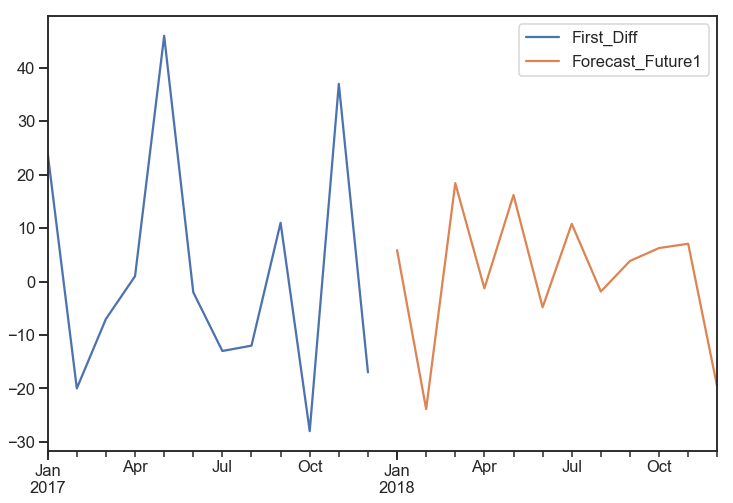

In [45]:
ts_month['Forecast_Future1'] = results.predict(start = 107, end = 119, dynamic= True)  
ts_month[['First_Diff', 'Forecast_Future1']].ix[-24:].plot(figsize=(12, 8))

### 10. Add Trend and Seasonality into the Series

In [46]:
cumsum = ts_month["Forecast_Future1"].cumsum(skipna = True)
ts_month["Forecast_Future1"] = cumsum + 227


In [47]:
# ts_month_future["Forecast"] = ts_month_future["Forecast"].fillna(0)
ts_month["Forecast_Future1"] = ts_month["Forecast_Future1"].round()
ts_month.tail(30)

,Accidents,First_Diff,Forecast_Test1,Forecast_Future1
2016-07-01,241,3.0,13.427952,NaN
2016-08-01,244,3.0,-3.856965,NaN
2016-09-01,240,-4.0,1.142804,NaN
2016-10-01,244,4.0,10.142390,NaN
2016-11-01,249,5.0,-0.285701,NaN
2016-12-01,207,-42.0,-19.284825,NaN
2017-01-01,231,24.0,2.285609,NaN
2017-02-01,211,-20.0,-27.430191,NaN
2017-03-01,204,-7.0,20.427630,NaN
2017-04-01,205,1.0,-3.714115,NaN


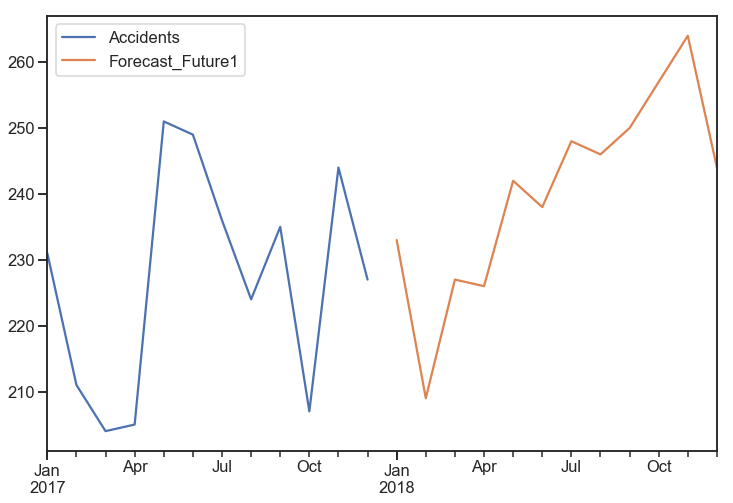

In [48]:
# ts_month_future[['Accidents', 'Forecast']].plot(figsize=(12, 8))
ts_month[['Accidents', 'Forecast_Future1']].ix[-24:].plot(figsize=(12, 8))

### Observations

The forecast started almost on the same point as the previous Jan. However, there was a steep rising trend from Feb to Mar as compared to the sharp dip in the previous period. Let's see if we can produce better models by tuning the parameters.

In [49]:
model2 = sm.tsa.statespace.SARIMAX(train,order=(0,0,1),seasonal_order=(0,0,1,12),
                                   enforce_stationarity=False, enforce_invertibility=False).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Accidents   No. Observations:                   85
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -318.789
Date:                            Tue, 26 Feb 2019   AIC                            643.579
Time:                                    17:15:40   BIC                            650.367
Sample:                                02-01-2009   HQIC                           646.278
                                     - 02-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6093      0.118     -5.182      0.000      -0.840      -0.379
ma.S.L12       0.0524      0.123      0.428      0.669      -0.188       0.293
sigma2       461.8000     74.068      6.235      0.000     316.629     606.971
===================================================================================
Ljung-Box (Q):                       42.11   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.38   Prob(JB):                         0.75
Heteroskedasticity (H):               1.21   Skew:                            -0.15
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
model3 = sm.tsa.statespace.SARIMAX(train,order=(0,0,0),seasonal_order=(1,0,0,12),
                                   enforce_stationarity=False, enforce_invertibility=False).fit()

model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                Accidents   No. Observations:                   85
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -340.515
Date:                  Tue, 26 Feb 2019   AIC                            685.029
Time:                          17:15:40   BIC                            689.610
Sample:                      02-01-2009   HQIC                           686.855
                           - 02-01-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1245      0.107      1.161      0.246      -0.086       0.335
sigma2       659.3759    118.376      5.570      0.000     427.364     891.388
===================================================================================
Ljung-Box (Q):                       45.74   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.25   Prob(JB):                         0.85
Heteroskedasticity (H):               0.93   Skew:                             0.10
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
model4 = sm.tsa.statespace.SARIMAX(train,order=(0,0,0),seasonal_order=(0,1,0,12),
                                   enforce_stationarity=False, enforce_invertibility=False).fit()

model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                Accidents   No. Observations:                   85
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -358.178
Date:                  Tue, 26 Feb 2019   AIC                            718.356
Time:                          17:15:40   BIC                            720.633
Sample:                      02-01-2009   HQIC                           719.262
                           - 02-01-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1225.9360    207.530      5.907      0.000     819.185    1632.687
===================================================================================
Ljung-Box (Q):                       86.24   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.20   Skew:                            -0.05
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
model5 = sm.tsa.statespace.SARIMAX(train,order=(0,0,0),seasonal_order=(0,0,0,12),
                                   enforce_stationarity=False, enforce_invertibility=False).fit()

model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              Accidents   No. Observations:                   85
Model:                        SARIMAX   Log Likelihood                -394.606
Date:                Tue, 26 Feb 2019   AIC                            791.212
Time:                        17:15:40   BIC                            793.643
Sample:                    02-01-2009   HQIC                           792.189
                         - 02-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       704.5042    118.314      5.955      0.000     472.614     936.395
===================================================================================
Ljung-Box (Q):                       49.43   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.15   Prob(JB):                         0.82
Heteroskedasticity (H):               0.83   Skew:                            -0.06
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
# Forecast with model 2. 
ts_month['Forecast_Test2'] = model2.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
forecast2 = model2.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  

# Forecast with model 3.
ts_month['Forecast_Test3'] = model3.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
forecast3 = model3.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  

# Forecast with model 4.
ts_month['Forecast_Test4'] = model4.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
forecast4 = model4.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
ts_month.tail(30)

# Forecast with model 5.
ts_month['Forecast_Test5'] = model5.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  
forecast5 = model5.predict(start="2016-03-01", end='2017-12-01', dynamic= True)  

ts_month.tail(30)

,Accidents,First_Diff,Forecast_Test1,Forecast_Future1,Forecast_Test2,Forecast_Test3,Forecast_Test4,Forecast_Test5
2016-07-01,241,3.0,13.427952,NaN,1.233261,2.988266,24.0,0.0
2016-08-01,244,3.0,-3.856965,NaN,-1.324013,-2.863755,-23.0,0.0
2016-09-01,240,-4.0,1.142804,NaN,1.536681,3.610822,29.0,0.0
2016-10-01,244,4.0,10.142390,NaN,-0.172989,-0.498044,-4.0,0.0
2016-11-01,249,5.0,-0.285701,NaN,0.592481,1.369622,11.0,0.0
2016-12-01,207,-42.0,-19.284825,NaN,-0.732258,-1.743155,-14.0,0.0
2017-01-01,231,24.0,2.285609,NaN,-1.123417,-2.490222,-20.0,0.0
2017-02-01,211,-20.0,-27.430191,NaN,-2.012582,-4.855933,-39.0,0.0
2017-03-01,204,-7.0,20.427630,NaN,1.681515,0.325563,21.0,0.0
2017-04-01,205,1.0,-3.714115,NaN,0.000000,-0.852666,-55.0,0.0


### Observations

In [54]:
# Calculate residuals for each point.
y_hat2 = ts_month.loc["2016-03-01":"2017-12-01"]["Forecast_Test2"]
y2 = ts_month.loc["2016-03-01":"2017-12-01"]["First_Diff"]
forecast_error2 = y2 - y_hat2

# Calculate residuals for each point.
y_hat3 = ts_month.loc["2016-03-01":"2017-12-01"]["Forecast_Test3"]
y3 = ts_month.loc["2016-03-01":"2017-12-01"]["First_Diff"]
forecast_error3 = y3 - y_hat3

# Calculate residuals for each point.
y_hat4 = ts_month.loc["2016-03-01":"2017-12-01"]["Forecast_Test4"]
y4 = ts_month.loc["2016-03-01":"2017-12-01"]["First_Diff"]
forecast_error4 = y4 - y_hat4

# Calculate residuals for each point.
y_hat5 = ts_month.loc["2016-03-01":"2017-12-01"]["Forecast_Test5"]
y5 = ts_month.loc["2016-03-01":"2017-12-01"]["First_Diff"]
forecast_error5 = y5 - y_hat5


In [55]:
# Model 1
print("Model 1")
mae1 = mean_absolute_error(y1, y_hat1)
mse1 = mean_squared_error(y1, y_hat1)
print('MAE: %f' % mae)
print('MSE: %f' % mse)


# Model 2
print("Model 2")
mae2 = mean_absolute_error(y2, y_hat2)
mse2 = mean_squared_error(y2, y_hat2)
print('MAE: %f' % mae2)
print('MSE: %f' % mse2)

# Model 3
print("Model 3")
mae3 = mean_absolute_error(y3, y_hat3)
mse3 = mean_squared_error(y3, y_hat3)
print('MAE: %f' % mae3)
print('MSE: %f' % mse2)


print("Model 4")
mae4 = mean_absolute_error(y4, y_hat4)
mse4 = mean_squared_error(y4, y_hat4)
print('MAE: %f' % mae4)
print('MSE: %f' % mse4)

print("Model 5")
mae5 = mean_absolute_error(y5, y_hat5)
mse5 = mean_squared_error(y5, y_hat5)
print('MAE: %f' % mae5)
print('MSE: %f' % mse5)

Model 1
MAE: 14.324666
MSE: 357.180449
Model 2
MAE: 14.713081
MSE: 393.548196
Model 3
MAE: 15.344239
MSE: 393.548196
Model 4
MAE: 21.409091
MSE: 697.136364
Model 5
MAE: 15.727273
MSE: 428.636364


### Observations

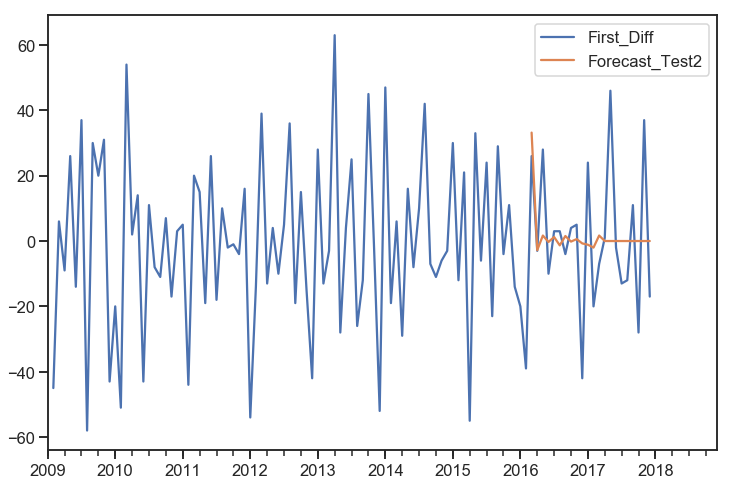

In [56]:
ts_month[['First_Diff', 'Forecast_Test2']].plot(figsize=(12, 8)) 

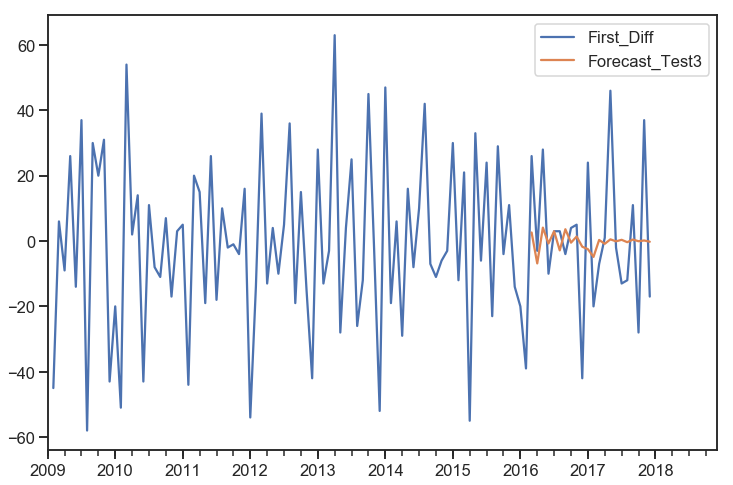

In [57]:
ts_month[['First_Diff', 'Forecast_Test3']].plot(figsize=(12, 8)) 

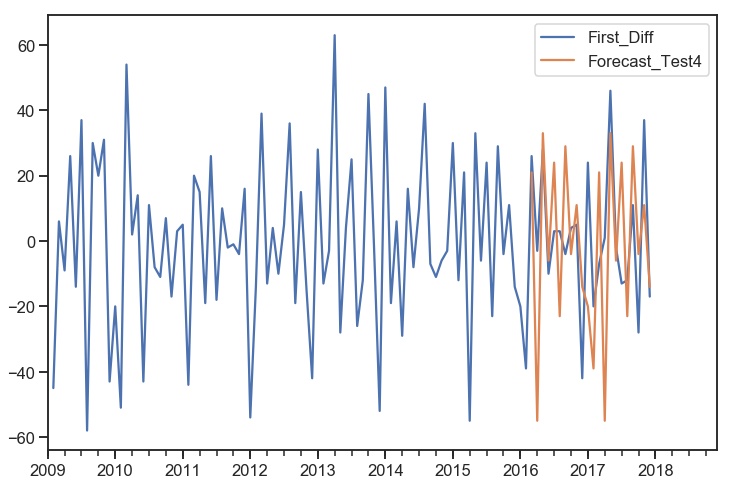

In [58]:
ts_month[['First_Diff', 'Forecast_Test4']].plot(figsize=(12, 8)) 

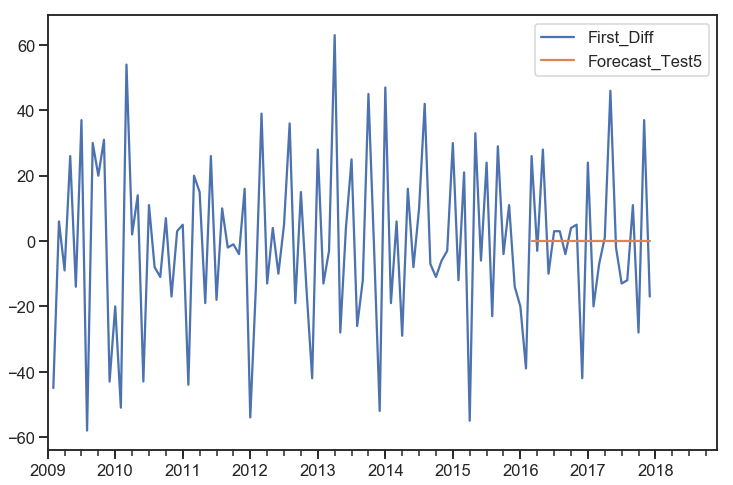

In [59]:
ts_month[['First_Diff', 'Forecast_Test5']].plot(figsize=(12, 8)) 

### Observations